<a href="https://colab.research.google.com/github/ShreyashDhoot/DataQuest/blob/main/Neuralscode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('train_data.csv')

In [ ]:
df = df.drop(columns=['account_number'])

In [ ]:
#make binary indicator for onus_attribute_1

In [ ]:
# Create a new binary feature based on the threshold
df['onus_attr1_below_500k'] = (df['onus_attribute_1'] < 500000).astype(int)

# Quick check: Compare default rates for the two groups
print(df.groupby('onus_attr1_below_410k')['bad_flag'].mean())

# Visualize the distribution of onus_attribute_1 with respect to this threshold
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='onus_attribute_1', hue='bad_flag', bins=50, kde=True)
plt.axvline(500000, color='red', linestyle='--', label='Threshold: 410,000')
plt.legend()
plt.title("Distribution of onus_attribute_1 by Default Status")
plt.show()


KeyError: 'onus_attr1_below_410k'

In [ ]:
import pandas as pd
import numpy as np
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# ---------------------------
# 1. Load Data and Drop High-Missing Columns
# ---------------------------
def load_and_drop_missing(file_path: str, target: str = 'bad_flag', missing_threshold: float = 0.50):
    """
    Load the CSV into a pandas DataFrame and drop columns where the fraction of missing values exceeds missing_threshold.
    """
    df = pd.read_csv(file_path)
    missing_pct = df.isnull().mean()
    cols_to_drop = missing_pct[missing_pct > missing_threshold].index.tolist()
    if cols_to_drop:
        print("Dropping columns with >50% missing values:", cols_to_drop)
        df.drop(columns=cols_to_drop, inplace=True)
    else:
        print("No columns with >50% missing values to drop.")
    return df

# ---------------------------
# 2. Train/Test Split and Median Imputation
# ---------------------------
def split_and_impute(df: pd.DataFrame, target: str = 'bad_flag', test_size: float = 0.2, random_state: int = 42):
    """
    Splits the DataFrame into train and test sets (stratified by target)
    and imputes missing numeric values with the median.
    """
    X = df.drop(columns=[target])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test

# ---------------------------
# 3. Remove Redundant Features by Target Correlation Using GPU (cuDF)
# ---------------------------
def remove_redundant_features_by_target_corr_gpu(df_train: pd.DataFrame, target: str, threshold: float = 0.95):
    """
    Remove one feature from each highly correlated pair based on their absolute correlation with the target.
    For each pair of numeric features with an absolute correlation > threshold,
    drop the feature with the lower absolute correlation to the target.

    Parameters:
        df_train: pandas DataFrame containing the training features and target.
        target: Name of the target column.
        threshold: Correlation threshold above which two features are considered redundant.

    Returns:
        List of features to drop.
    """
    # Select numeric columns (excluding target)
    numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
    if target in numeric_cols:
        numeric_cols.remove(target)

    # Convert to cuDF DataFrame
    df_gpu = cudf.DataFrame.from_pandas(df_train[numeric_cols])
    # Compute absolute correlation matrix on GPU
    corr_matrix_gpu = df_gpu.corr().abs()
    corr_matrix = corr_matrix_gpu.to_pandas()

    # Compute absolute correlation with target for each numeric feature (pandas)
    target_corr = {col: abs(df_train[col].corr(df_train[target])) for col in numeric_cols}

    # Use only upper triangle to avoid duplicates
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    dropped_features = set()
    for col in upper_tri.columns:
        if col in dropped_features:
            continue
        high_corr_features = upper_tri.index[upper_tri[col] > threshold].tolist()
        for other in high_corr_features:
            if other in dropped_features:
                continue
            # Compare absolute correlations with target and drop the one with lower correlation
            if target_corr[other] < target_corr[col]:
                dropped_features.add(other)
            else:
                dropped_features.add(col)
                break  # Exit inner loop once col is dropped

    return list(dropped_features)

# ---------------------------
# 4. Remove Low-Correlation Features from Training Set
# ---------------------------
def remove_low_correlation_features(df_train: pd.DataFrame, target: str, threshold: float = 0.017):
    """
    Remove numeric features from df_train that have an absolute correlation with the target below the threshold.

    Parameters:
        df_train: pandas DataFrame containing the features and target.
        target: Name of the target column.
        threshold: Minimum absolute correlation to keep a feature.

    Returns:
        List of features to drop.
    """
    numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
    if target in numeric_cols:
        numeric_cols.remove(target)
    corr_with_target = {col: abs(df_train[col].corr(df_train[target])) for col in numeric_cols}
    low_corr_features = [col for col in numeric_cols if corr_with_target[col] < threshold]
    return low_corr_features

# ---------------------------
# 5. Main Execution
# ---------------------------
if __name__ == "__main__":
    # File path to your CSV data
    file_path = "train_data.csv"  # Update path as needed
    target = "bad_flag"

    # Step 1: Load data and drop columns with >50% missing values
    df = load_and_drop_missing(file_path, target=target, missing_threshold=0.50)

    # Step 2: Split into train/test sets and perform median imputation
    X_train, X_test, y_train, y_test = split_and_impute(df, target=target, test_size=0.2, random_state=42)

    # Combine training features and target for feature removal operations
    df_train = X_train.copy()
    df_train[target] = y_train.values

    # Step 3: Remove redundant features based on high inter-feature correlation
    redundant_features = remove_redundant_features_by_target_corr_gpu(df_train, target=target, threshold=0.95)
    print("Redundant features to drop (based on lower correlation with target):", redundant_features)

    df_train_reduced = df_train.drop(columns=redundant_features, errors='ignore')

    # Step 4: Remove features with low correlation with target (abs corr < 0.017)
    low_corr_features = remove_low_correlation_features(df_train_reduced, target=target, threshold=0.017)
    print("Low correlation features to drop:", low_corr_features)

    # Combine the lists of features to drop
    features_to_drop = redundant_features + low_corr_features

    # Create final training DataFrame with target
    df_train_final = df_train.drop(columns=features_to_drop, errors='ignore')
    print("Final training set shape (with target):", df_train_final.shape)

    # Separate training features and target for modeling
    X_train_final = df_train_final.drop(columns=[target], errors='ignore')
    y_train_final = df_train_final[target]

    # Drop the same features from the test set
    X_test_final = X_test.drop(columns=features_to_drop, errors='ignore')

    print("Final training features shape:", X_train_final.shape)
    print("Final test features shape:", X_test_final.shape)

    # At this point, you have a tailored dataset:
    # - Columns with >50% missing values dropped.
    # - Missing values imputed with median.
    # - Redundant features (highly correlated with each other) removed (based on lower correlation with target).
    # - Features with almost zero correlation with target (abs corr < 0.017) removed.

    # You can now proceed with further feature engineering or modeling.


Dropping columns with >50% missing values: ['bureau_148', 'bureau_433', 'bureau_435', 'bureau_436', 'bureau_437', 'bureau_438', 'bureau_444', 'bureau_445', 'bureau_446', 'bureau_447', 'bureau_448', 'bureau_449', 'bureau_451', 'onus_attribute_43', 'onus_attribute_44', 'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47', 'onus_attribute_48']


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Redundant features to drop (based on lower correlation with target): ['bureau_58', 'bureau_440', 'transaction_attribute_159', 'transaction_attribute_164', 'transaction_attribute_328', 'transaction_attribute_652', 'transaction_attribute_658', 'bureau_407', 'onus_attribute_42', 'bureau_294', 'transaction_attribute_628', 'transaction_attribute_468', 'transaction_attribute_486', 'transaction_attribute_100', 'transaction_attribute_522', 'transaction_attribute_650', 'transaction_attribute_392', 'onus_attribute_11', 'bureau_enquiry_33', 'onus_attribute_16', 'transaction_attribute_81', 'bureau_76', 'transaction_attribute_101', 'transaction_attribute_278', 'transaction_attribute_493', 'transaction_attribute_322', 'transaction_attribute_234', 'transaction_attribute_151', 'bureau_116', 'transaction_attribute_531', 'transaction_attribute_245', 'transaction_attribute_295', 'transaction_attribute_373', 'transaction_attribute_13', 'bureau_8', 'transaction_attribute_254', 'bureau_33', 'bureau_263', 't

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Low correlation features to drop: ['account_number', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5', 'transaction_attribute_6', 'transaction_attribute_8', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_12', 'transaction_attribute_14', 'transaction_attribute_15', 'transaction_attribute_16', 'transaction_attribute_17', 'transaction_attribute_18', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_21', 'transaction_attribute_25', 'transaction_attribute_26', 'transaction_attribute_27', 'transaction_attribute_29', 'transaction_attribute_30', 'transaction_attribute_31', 'transaction_attribute_32', 'transaction_attribute_33', 'transaction_attribute_34', 'transaction_attribute_35', 'transaction_attribute_36', 'transaction_attribute_37', 'transaction_attribute_38', 'transaction_attribute_39', 'transaction_attribute_40', 'transaction_attribute_41', 'transaction_attribute_42', '

In [ ]:
# Create final processed training DataFrame (including target)
df_train_processed = df_train.drop(columns=features_to_drop, errors='ignore')

# Separate training features and target
X_train_processed = df_train_processed.drop(columns=[target], errors='ignore')
y_train_processed = df_train_processed[target]

# Remove the same features from the test set
X_test_processed = X_test.drop(columns=features_to_drop, errors='ignore')
y_test_processed = y_test  # Rename y_test to y_test_processed for consistency


print("X_train_processed shape:", X_train_processed.shape)
print("y_train_processed shape:", y_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)
print("y_test_processed shape:", y_test_processed.shape)


X_train_processed shape: (61955, 257)
y_train_processed shape: (61955,)
X_test_processed shape: (15489, 257)
y_test_processed shape: (15489,)


Unified DataFrame for EDA:
Shape: (61955, 258)
       onus_attribute_1  transaction_attribute_22  transaction_attribute_23  \
57065          233000.0                       0.0                       0.0   
46871          100000.0                       0.0                       0.0   
41173          130000.0                       0.0                       0.0   
25970           96000.0                       0.0                       0.0   
45728          350000.0                       0.0                       0.0   

       transaction_attribute_24  transaction_attribute_52  \
57065                       0.0                       0.0   
46871                       0.0                       0.0   
41173                       0.0                       0.0   
25970                       0.0                       0.0   
45728                       0.0                       0.0   

       transaction_attribute_53  transaction_attribute_54  \
57065                       0.0                   

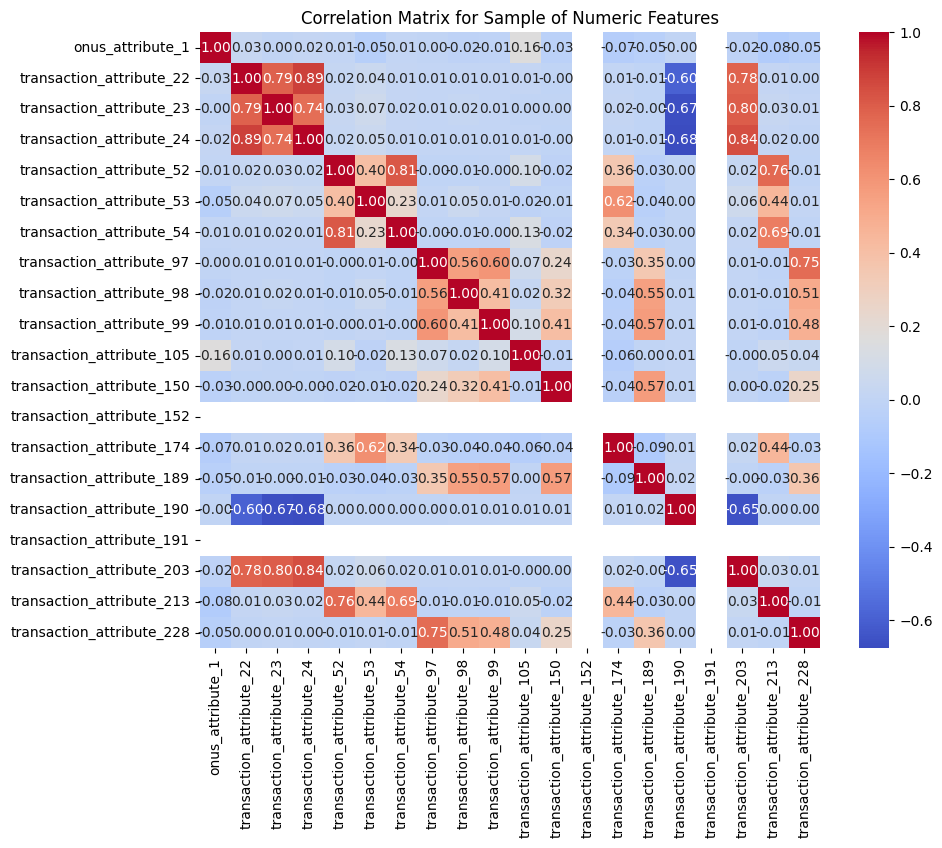

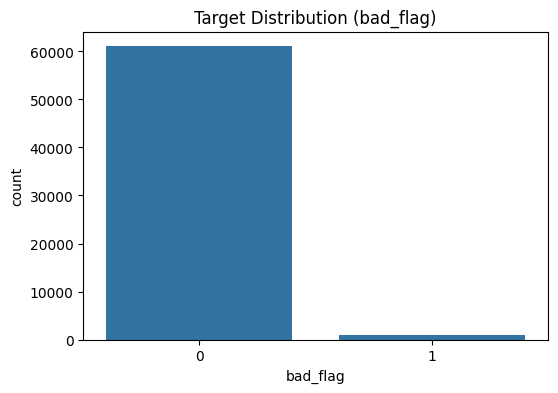

In [ ]:
# Create unified DataFrame for EDA by concatenating features and target
df_eda = pd.concat([X_train_processed, y_train_processed], axis=1)

# Basic Info
print("Unified DataFrame for EDA:")
print("Shape:", df_eda.shape)
print(df_eda.head())
print("\nDataFrame Info:")
print(df_eda.info())

# Missing Values Summary
missing_pct = df_eda.isnull().mean() * 100
print("\nMissing values percentage per column (top 10):")
print(missing_pct.sort_values(ascending=False).head(10))

# Descriptive Statistics
print("\nDescriptive Statistics:")
print(df_eda.describe())

# Correlation Matrix for a sample of numeric columns (for example, first 20 numeric columns)
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
sample_numeric = numeric_cols[:20]  # sample first 20 numeric columns for plotting
corr_matrix = df_eda[sample_numeric].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Sample of Numeric Features")
plt.show()

# Plot Target Distribution (assuming target is 'bad_flag')
plt.figure(figsize=(6, 4))
sns.countplot(x='bad_flag', data=df_eda)
plt.title("Target Distribution (bad_flag)")
plt.show()

=== Basic Overview ===
Shape of df_eda: (61955, 258)

First 5 rows:
       onus_attribute_1  transaction_attribute_22  transaction_attribute_23  \
57065          233000.0                       0.0                       0.0   
46871          100000.0                       0.0                       0.0   
41173          130000.0                       0.0                       0.0   
25970           96000.0                       0.0                       0.0   
45728          350000.0                       0.0                       0.0   

       transaction_attribute_24  transaction_attribute_52  \
57065                       0.0                       0.0   
46871                       0.0                       0.0   
41173                       0.0                       0.0   
25970                       0.0                       0.0   
45728                       0.0                       0.0   

       transaction_attribute_53  transaction_attribute_54  \
57065                       0

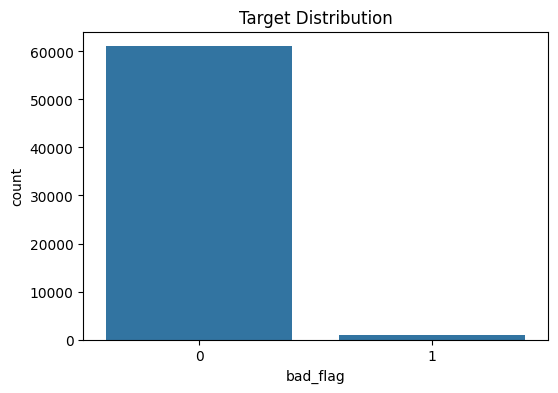

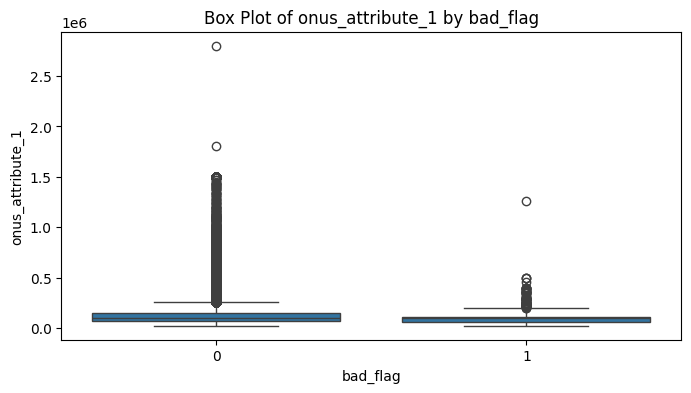

In [ ]:
# --- Sanity Check 1: Basic Overview ---
print("=== Basic Overview ===")
print("Shape of df_eda:", df_eda.shape)
print("\nFirst 5 rows:")
print(df_eda.head())
print("\nData Types:")
print(df_eda.dtypes)

# --- Sanity Check 2: Missing Values ---
print("\n=== Missing Values ===")
missing_values = df_eda.isnull().sum()
missing_pct = (missing_values / len(df_eda)) * 100
missing_summary = pd.DataFrame({"Missing Count": missing_values, "Missing %": missing_pct})
print(missing_summary.sort_values(by="Missing %", ascending=False).head(10))

# --- Sanity Check 3: Duplicate Rows ---
print("\n=== Duplicate Rows Check ===")
duplicates = df_eda.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# --- Sanity Check 4: Constant or Low-Variance Columns ---
print("\n=== Constant/Low-Variance Columns ===")
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns
low_variance = df_eda[numeric_cols].std().loc[lambda s: s < 1e-5]
print("Columns with near-zero variance:", low_variance.index.tolist())

# --- Sanity Check 5: Summary Statistics ---
print("\n=== Summary Statistics (Numeric Columns) ===")
print(df_eda[numeric_cols].describe())

# --- Sanity Check 6: Check Range of a Sample of Features ---
print("\n=== Feature Range Check ===")
sample_features = numeric_cols[:10]  # check first 10 numeric features
for col in sample_features:
    min_val = df_eda[col].min()
    max_val = df_eda[col].max()
    print(f"{col}: min = {min_val}, max = {max_val}")

# --- Sanity Check 7: Correlation Check for Target (if target is numeric or binary) ---
target = 'bad_flag'
if target in df_eda.columns:
    target_corr = df_eda.corr()[target].drop(target)
    print("\n=== Correlation with Target ===")
    print(target_corr.sort_values(ascending=False).head(10))
    print(target_corr.sort_values(ascending=True).head(10))

# --- Sanity Check 8: Visual Sanity Check ---
# Histogram of target variable
plt.figure(figsize=(6,4))
sns.countplot(x=target, data=df_eda)
plt.title("Target Distribution")
plt.show()

# Boxplot of a sample feature to inspect outliers
if sample_features.size > 0:
    sample_feature = sample_features[0]
    plt.figure(figsize=(8,4))
    sns.boxplot(x=target, y=sample_feature, data=df_eda)
    plt.title(f"Box Plot of {sample_feature} by {target}")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
df_train = pd.concat([X_train_processed, y_train_processed], axis=1)

# 2. Combine test features and target into another DataFrame
df_test = pd.concat([X_test_processed, y_test_processed], axis=1)

# 3. Stack them vertically into one DataFrame
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Check result
print("Combined DataFrame shape:", df_combined.shape)
print(df_combined.head())
print(df_combined.tail())

Combined DataFrame shape: (77444, 258)
   onus_attribute_1  transaction_attribute_22  transaction_attribute_23  \
0          233000.0                       0.0                       0.0   
1          100000.0                       0.0                       0.0   
2          130000.0                       0.0                       0.0   
3           96000.0                       0.0                       0.0   
4          350000.0                       0.0                       0.0   

   transaction_attribute_24  transaction_attribute_52  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   transaction_attribute_53  transaction_attribute_54  \
0                       0.0                       0.0   
1                       0.0                       0.0

In [ ]:
df_combined

,onus_attribute_1,transaction_attribute_22,transaction_attribute_23,transaction_attribute_24,transaction_attribute_52,transaction_attribute_53,transaction_attribute_54,transaction_attribute_97,transaction_attribute_98,transaction_attribute_99,...,bureau_enquiry_37,bureau_enquiry_38,bureau_enquiry_40,bureau_enquiry_42,bureau_enquiry_43,bureau_enquiry_45,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_50,bad_flag
0,233000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.0,7.0,98.0,27.0,0.0,0.0,39.0,0
1,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,12.0,3.0,0.0,0.0,7.0,0
2,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,1.0,12.0,2.0,0.0,1.0,7.0,0
3,96000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,11.0,0.0,0.0,0.0,8.0,0
4,350000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77439,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,3.0,0
77440,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,6.0,5.0,0.0,0.0,1.0,0
77441,33000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0
77442,152000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,17.0,4.0,0.0,0.0,6.0,0


In [ ]:
df = df_combined

In [ ]:
target_col = "bad_flag"

# Split data based on target values
num_1 = int(len(df[df[target_col] == 1]) * 0.45)
num_0 = int(len(df[df[target_col] == 0]) * 0.55)

data_1 = df[df[target_col] == 1].sample(n=num_1, random_state=42)
data_0 = df[df[target_col] == 0].sample(n=num_0, random_state=42)

In [ ]:
# Create training data
train_data = pd.concat([data_1, data_0]).sample(frac=1, random_state=42).reset_index(drop=True)
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

In [ ]:
# The remaining data will be used as test data
remaining_data = df.drop(train_data.index)
X_test = remaining_data.drop(columns=[target_col])
y_test = remaining_data[target_col]

In [ ]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Calculate scale_pos_weight (ratio of class 0 to class 1)
num_0 = len(df[df[target_col] == 0])
num_1 = len(df[df[target_col] == 1])
scale_pos_weight = num_0 / num_1  # Penalizes misclassification of fraud cases

In [ ]:
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight  # Balances class weights
)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:50:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Get probability predictions
y_prob = model.predict_proba(X_test)[:, 1]

# Adjust threshold for better fraud detection
threshold = 0.35  # Lower threshold to flag more fraud cases
y_pred = (y_prob > threshold).astype(int)

In [ ]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.9869
F1 Score: 0.5000
Precision: 0.5545
Recall: 0.4553
Confusion Matrix:
[[34274   184]
 [  274   229]]
ROC AUC: 0.8285


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from IPython.display import FileLink

# ----- Load Test Data -----
df_test = pd.read_csv("test_data.csv")

# Extract account numbers (primary key)
account_numbers = df_test["account_number"]
X_test_raw = df_test.drop(columns=["account_number"])

# ----- Select Numeric Columns and Drop Completely Missing Ones -----
X_test_numeric = X_test_raw.select_dtypes(include=["int64", "float64"])
X_test_numeric = X_test_numeric.dropna(axis=1, how="all")
numeric_cols = X_test_numeric.columns.tolist()
print("X_test_numeric shape:", X_test_numeric.shape)

# ----- Impute Missing Values with Median -----
imputer = SimpleImputer(strategy="median")
X_test_imputed_array = imputer.fit_transform(X_test_numeric)
print("Imputed array shape:", X_test_imputed_array.shape)

# Create DataFrame using X_test_numeric columns and index
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=X_test_numeric.columns, index=X_test_numeric.index)

# ----- Drop Features as Determined During Training -----
# Assume 'features_to_drop' is defined from training (redundant and low-correlation removal)
# Then drop these features from the imputed test set.
X_test_reduced = X_test_imputed.drop(columns=features_to_drop, errors="ignore")
print("After dropping features, X_test_reduced shape:", X_test_reduced.shape)

# ----- Align Test Set Columns with Training Set Columns -----
# Here we assume that X_train_processed is defined from training and contains the expected feature set.
expected_columns = X_train_processed.columns.tolist()
# Reindex the test DataFrame to ensure it has exactly the same columns (extra columns will be dropped,
# missing ones will be filled with 0, or you can choose another fill_value)
X_test_processed = X_test_reduced.reindex(columns=expected_columns, fill_value=0)
print("Final X_test_processed shape:", X_test_processed.shape)

# ----- Generate Predictions Using Your Trained Model -----
# 'model' is assumed to be your trained model with the feature space matching X_train_processed.
predicted_probabilities = model.predict_proba(X_test_processed)[:, 1]

# ----- Create Submission File -----
submission = pd.DataFrame({
    "account_number": account_numbers,
    "predicted_probability": predicted_probabilities
})

submission_file = "credit_default_predictions.csv"
submission.to_csv(submission_file, index=False)
print(f"Submission saved to {submission_file}")

# Display download link (if using a notebook environment)
display(FileLink(submission_file))


X_test_numeric shape: (19362, 1212)
Imputed array shape: (19362, 1212)
After dropping features, X_test_reduced shape: (19362, 274)
Final X_test_processed shape: (19362, 257)
Submission saved to credit_default_predictions.csv


/content/credit_default_predictions.csv

In [ ]:
from google.colab import files
files.download('credit_default_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>